In [ ]:
!git clone https://github.com/bearpelican/musicautobot.git

In [ ]:
import os
os.chdir('musicautobot')

In [ ]:
!apt install musescore fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  avahi-daemon bind9-host desktop-file-utils fluid-soundfont-gm
  fluidr3mono-gm-soundfont geoclue-2.0 geoip-database
  gstreamer1.0-plugins-base iio-sensor-proxy libavahi-core7 libavahi-glib1
  libbind9-160 libbrotli1 libcap2-bin libcdparanoia0 libdaemon0 libdns1100
  libfluidsynth1 libgeoclue-2-0 libgeoip1 libgl1-mesa-glx
  libgstreamer-plugins-base1.0-0 libgstreamer1.0-0 libhyphen0 libisc169
  libisccc160 libisccfg160 liblwres160 libmbim-glib4 libmbim-proxy libmm-glib0
  libnl-genl-3-200 libnss-mdns liborc-0.4-0 libpam-cap libportaudio2
  libpulsedsp libqmi-glib5 libqmi-proxy libqt5help5 libqt5positioning5
  libqt5qml5 libqt5quick5 libqt5sensors5 libqt5sql5-sqlite libqt5svg5


In [ ]:
!pip install torch fastai music21 pebble fluidsynth midi2audio

  Created wheel for fluidsynth: filename=fluidsynth-0.2-py3-none-any.whl size=4513 sha256=abdc0bae0deda51da0836d6b5272a0ce014a6f849a2c09de730d20856af406c9
  Stored in directory: /root/.cache/pip/wheels/44/4b/81/dee2d535b2dd27af13c230ba49aa6f05a5dff0f57c68acef55
Successfully built fluidsynth


In [ ]:
!pip install musicautobot

In [ ]:
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.utils.setup_musescore import setup_musescore
setup_musescore()

In [ ]:
from midi2audio import FluidSynth
from IPython.display import Audio

In [ ]:
#convert .midi to .wav
def play_wav(stream):
    out_midi = stream.write('midi')
    out_wav = str(Path(out_midi).with_suffix('.wav'))
    FluidSynth("font.sf2").midi_to_audio(out_midi, out_wav)
    return Audio(out_wav)

In [ ]:
midi_path =  Path('/content/drive/MyDrive/data/midi/examples/Bach')
data_path = Path('/content/drive/MyDrive/data/numpy')

In [ ]:
# For empty data
#data = MusicDataBunch.empty(data_path)
# For Saved Data:
data = load_data(data_path, 'musicitem_data_save.pkl')
vocab = data.vocab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
# Download pretrained model
pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MusicTransformerKeyC.pth'
# another pretrained model: pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MusicTransformer.pth'
pretrained_path = data_path/'pretrained'/Path(pretrained_url).name
pretrained_path.parent.mkdir(parents=True, exist_ok=True)
download_url(pretrained_url, dest=pretrained_path)

In [ ]:
learn = music_model_learner(data, pretrained_path=pretrained_path)

In [ ]:
midi_files = get_files(midi_path, recurse=True, extensions='.mid'); midi_files[:26]

[PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/1080-c01.mid'),
 PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/1080-c02.mid'),
 PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/1080c02b.mid'),
 PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/1080-c12.mid'),
 PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/kunst_der_fuge_19_(c)simonetto.mid')]

In [ ]:
idx = 0
f = midi_files[idx]; f

PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/1080-c01.mid')

In [ ]:
cutoff_beat = 100

item = MusicItem.from_file(f, data.vocab)
seed_item = item.trim_to_beat(cutoff_beat)

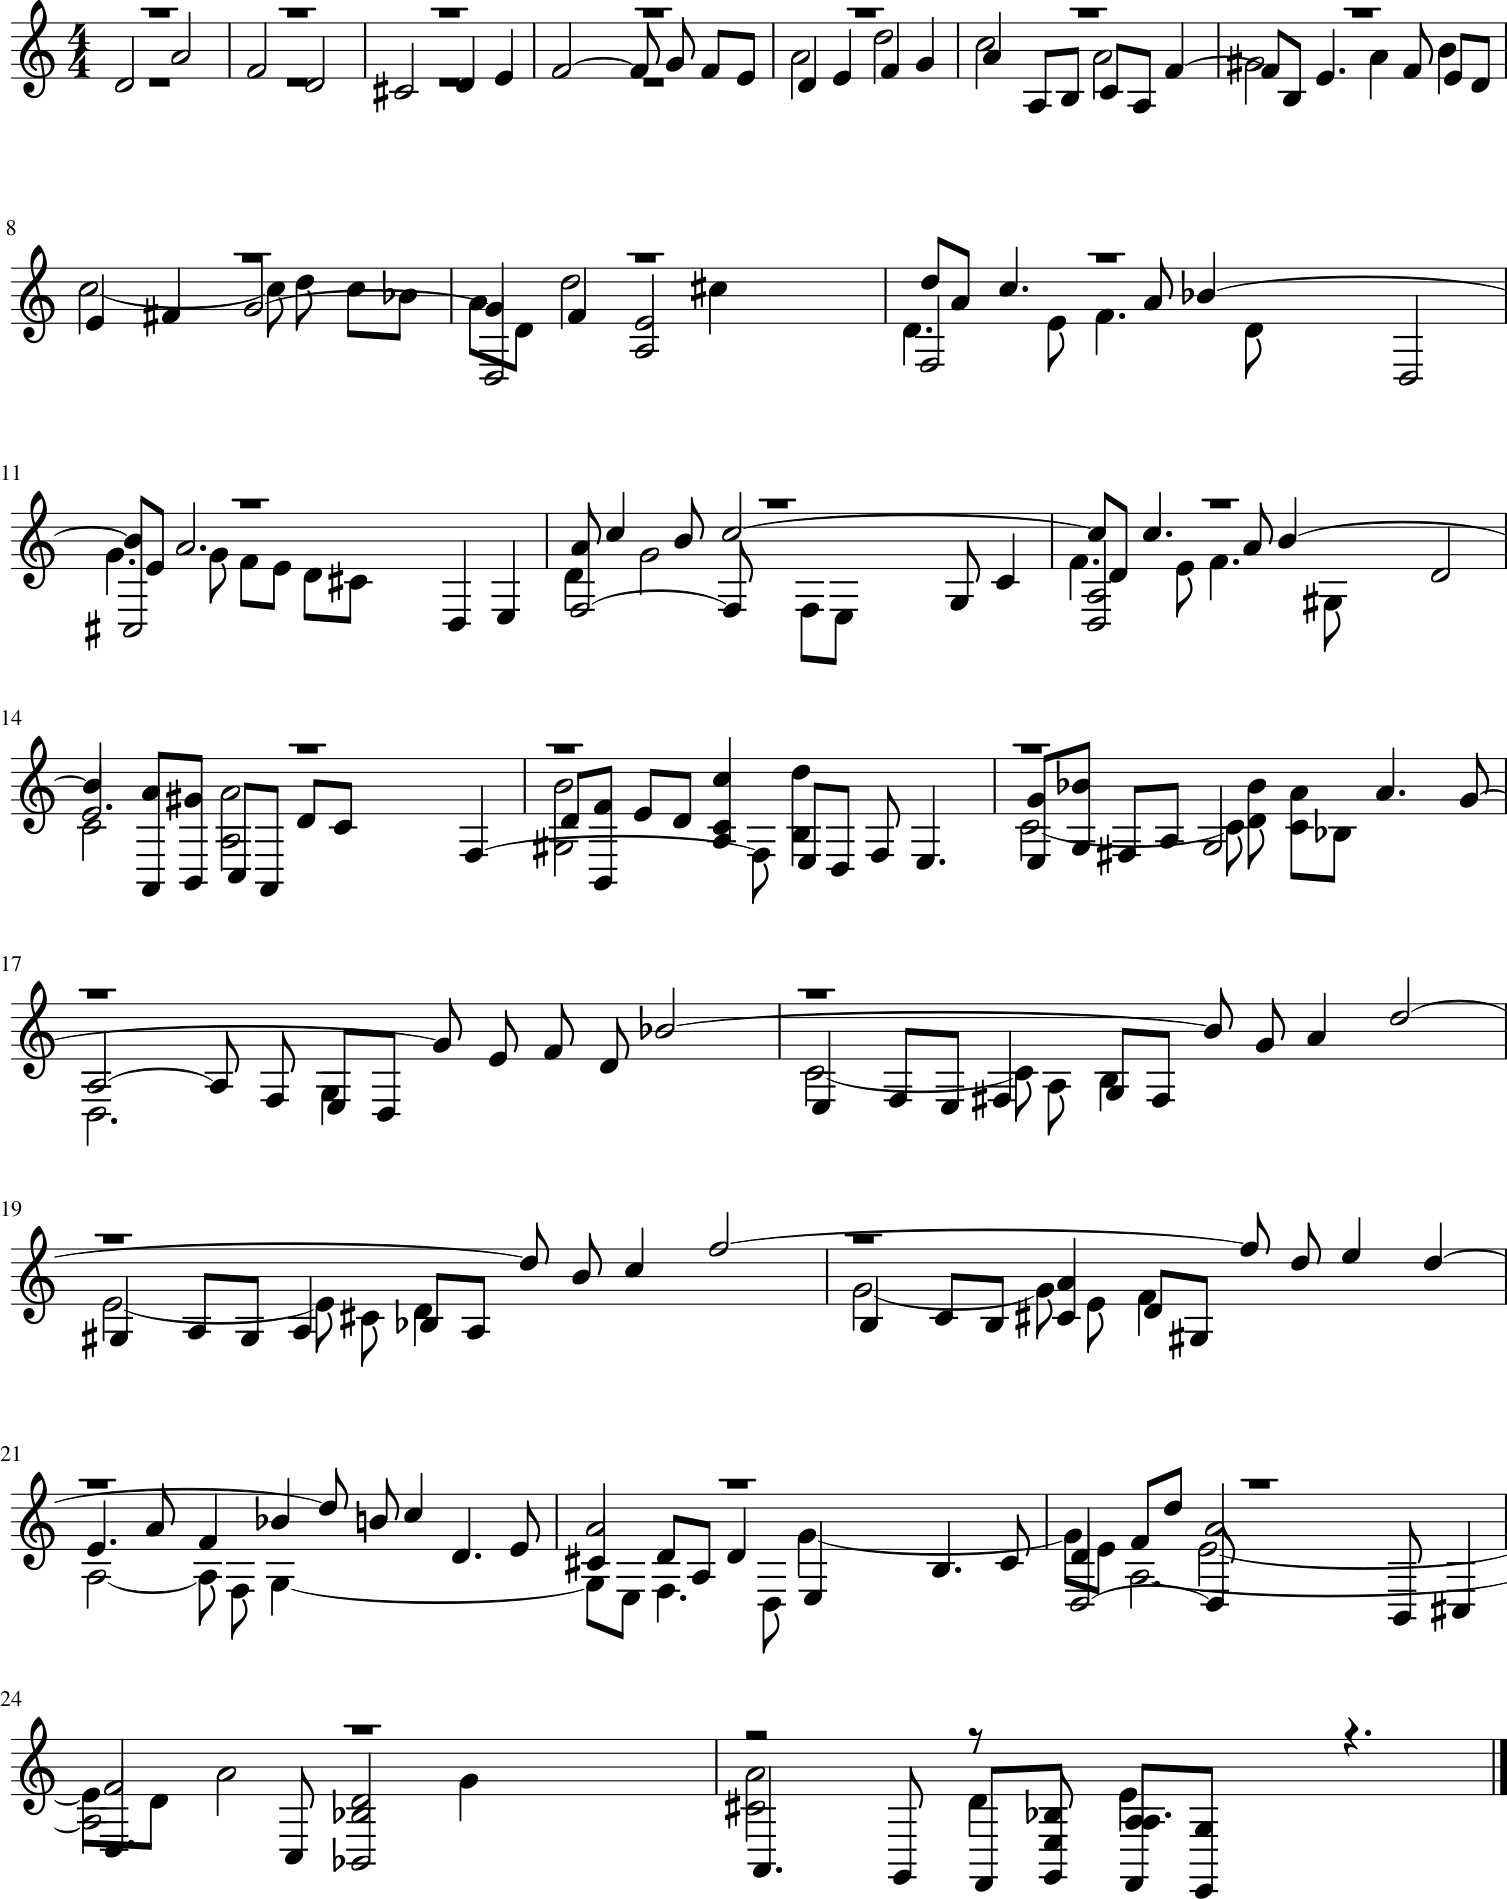

In [ ]:
seed_item.show()

In [ ]:
play_wav(seed_item.stream)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
pred, full = learn.predict(seed_item, n_words=600, temperatures=(1.1,0.4), min_bars=12, top_k=24, top_p=0.7)

/content/musicautobot/musicautobot/music_transformer/model.py:63: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bar_pos = pos // self.beat_len % self.max_bar_len
/content/musicautobot/musicautobot/music_transformer/learner.py:120: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if ((last_pos - start_pos) // 16) <= min_bars: logits[vocab

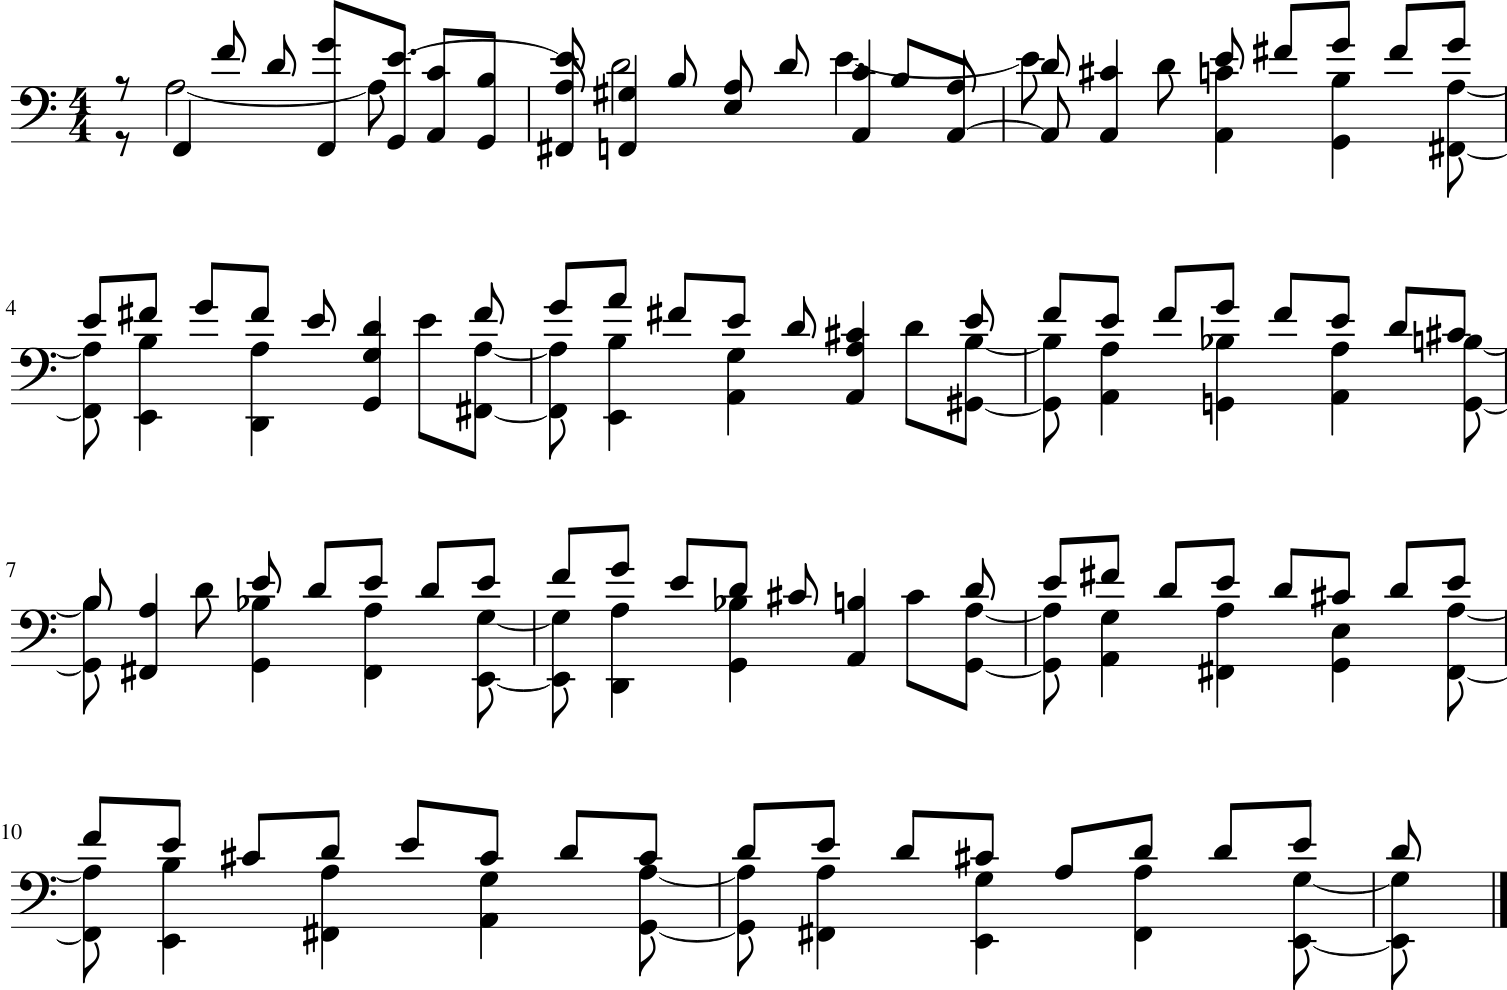

In [ ]:
pred.show()

In [ ]:
play_wav(pred.stream)

Output hidden; open in https://colab.research.google.com to view.

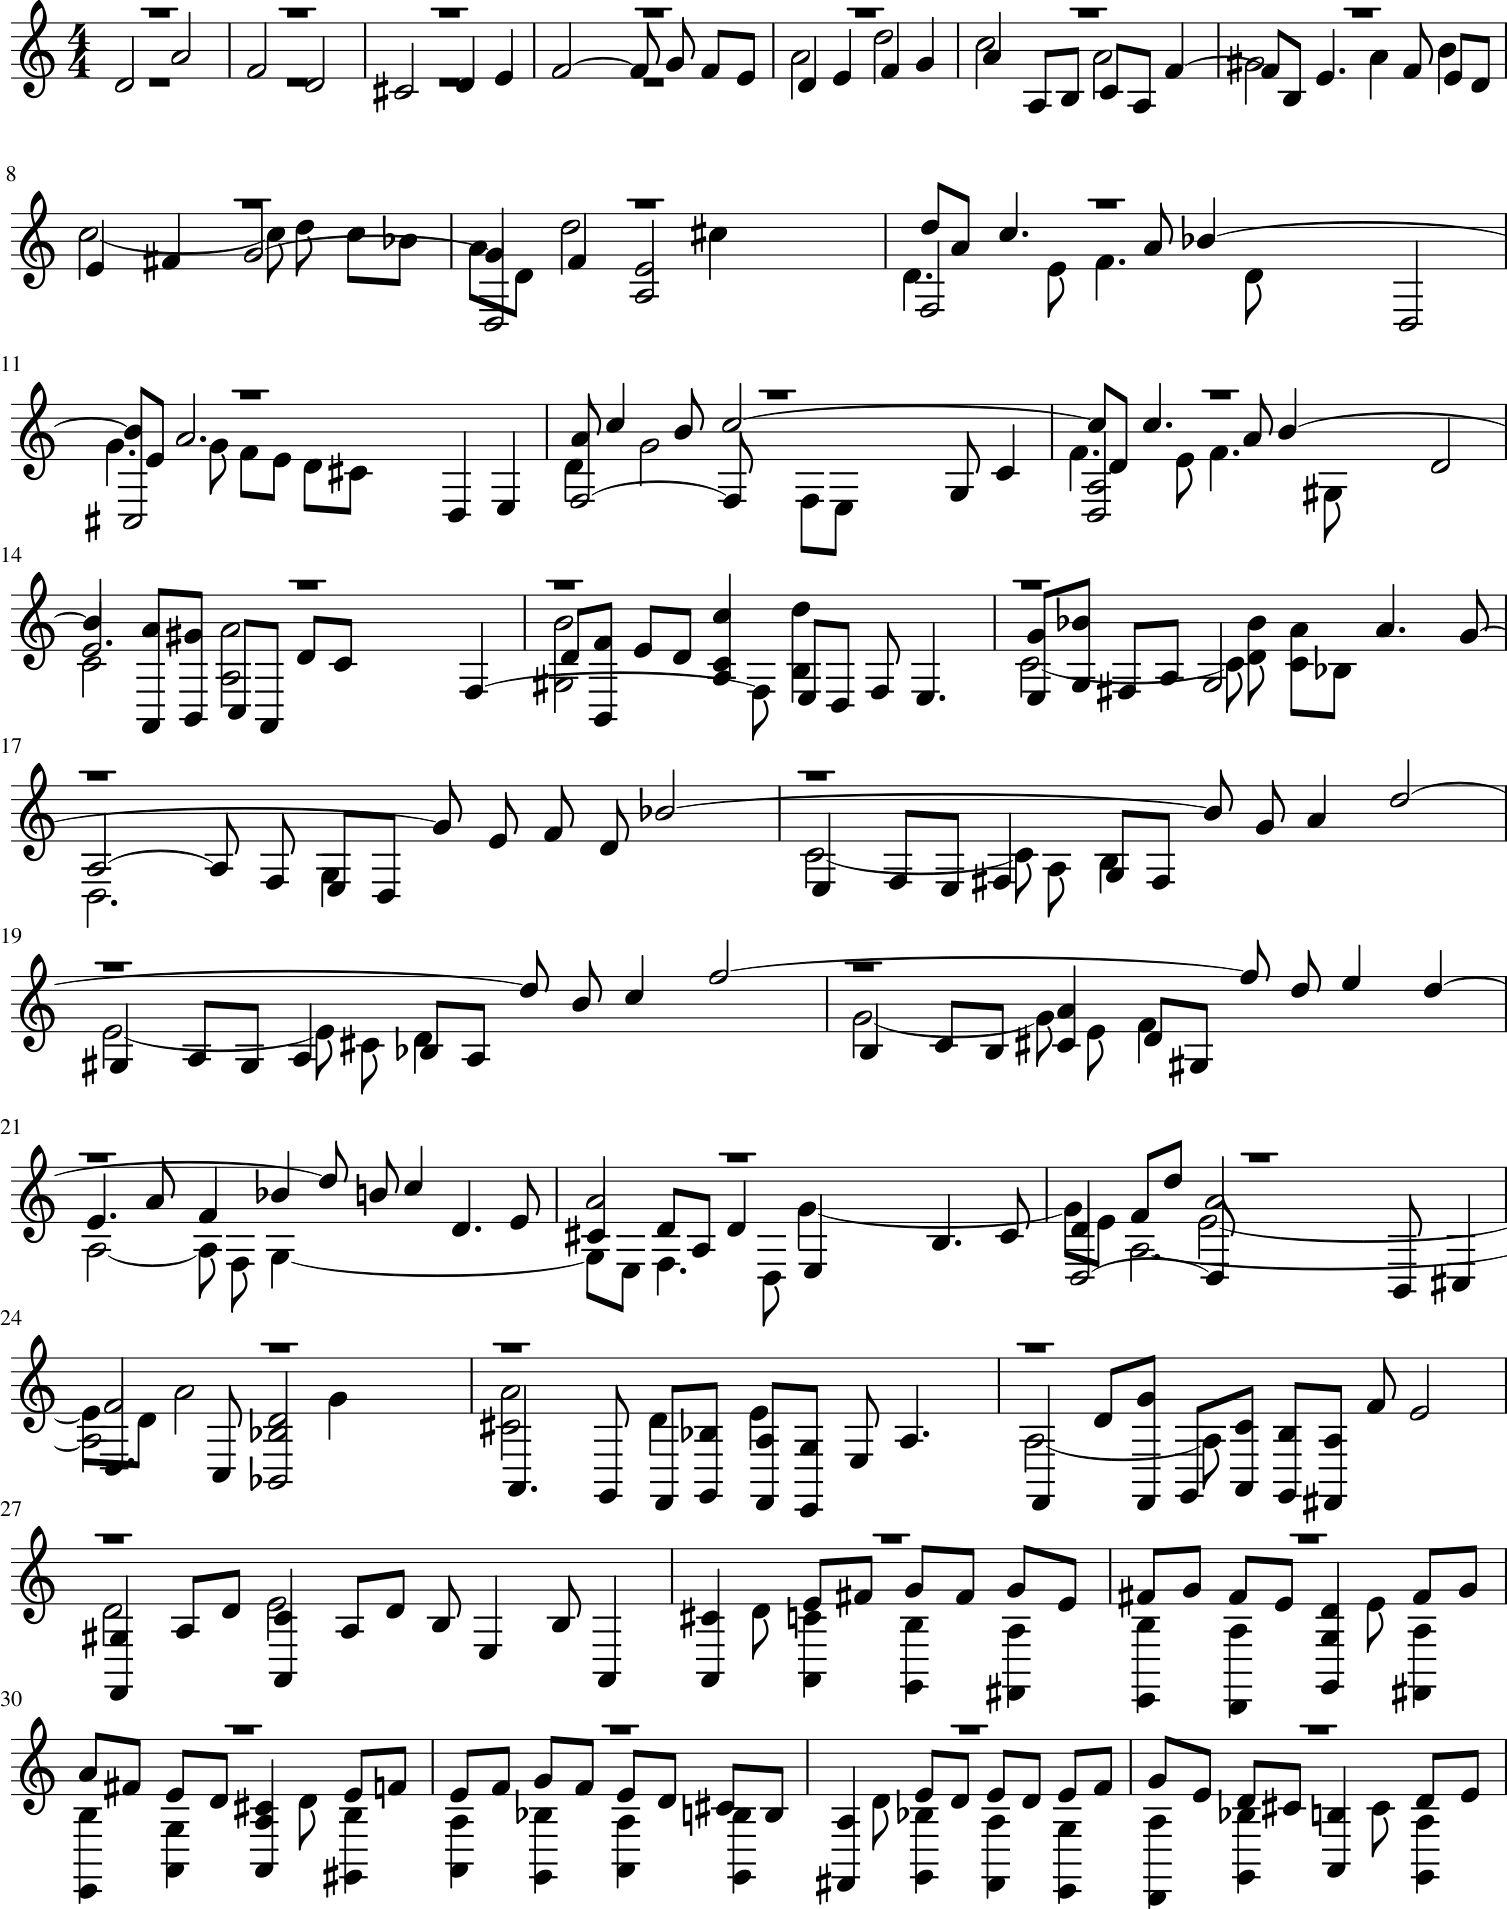

In [ ]:
full_song = seed_item.append(pred); full_song.show()

In [ ]:
play_wav(full_song.stream)

Output hidden; open in https://colab.research.google.com to view.

Add random noise

In [ ]:
note_temp = 1.4 # Determines variation
dur_temp = 0.8 # Determines randomness
top_k = 30
pred, full = learn.predict(seed_item, n_words=600, temperatures=(note_temp, dur_temp), min_bars=12, top_k=top_k, top_p=0.7)

/content/musicautobot/musicautobot/music_transformer/model.py:63: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bar_pos = pos // self.beat_len % self.max_bar_len
/content/musicautobot/musicautobot/music_transformer/learner.py:120: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if ((last_pos - start_pos) // 16) <= min_bars: logits[vocab

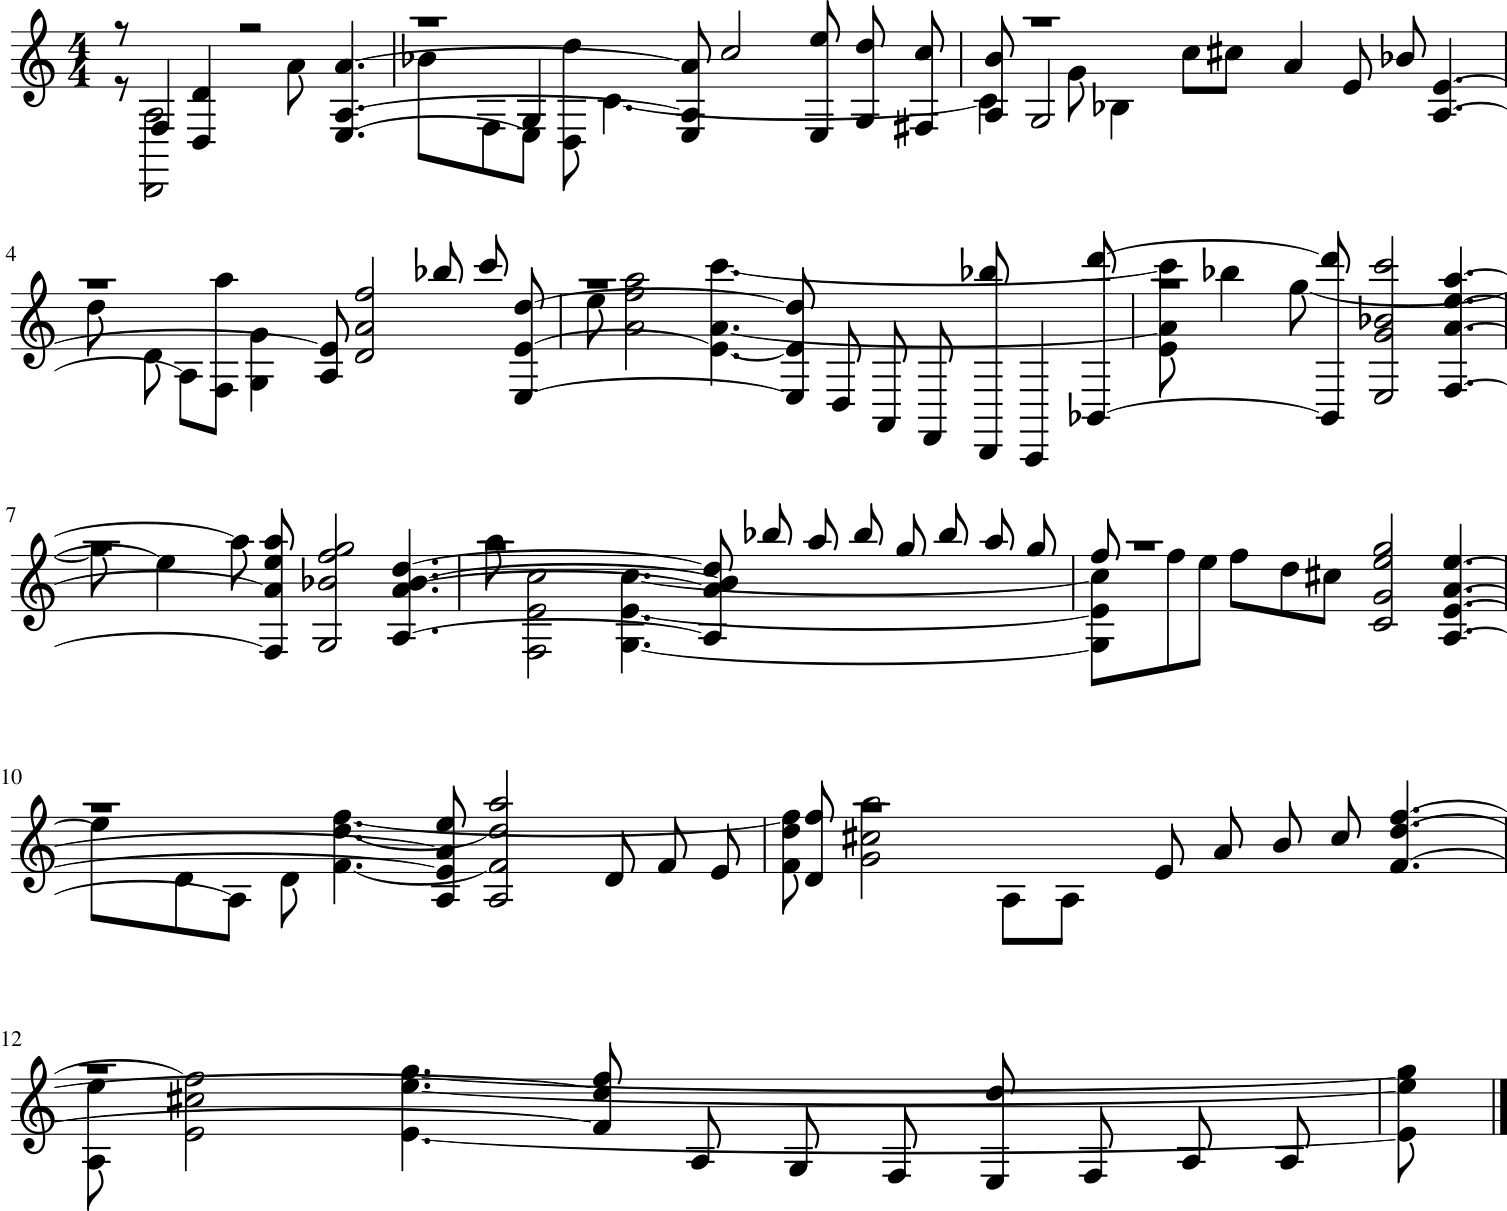

In [ ]:
pred.show()

In [ ]:
play_wav(pred.stream)

Output hidden; open in https://colab.research.google.com to view.